In [2]:
import math
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from pandas import Series, DataFrame
import pandas as pd
import nltk
%pylab inline 


Populating the interactive namespace from numpy and matplotlib


## Part A (Basic Text Mining)

In [3]:
jobs = pd.read_csv("../Data/train_rev1.csv") # 244,768 records
jobs_sample = jobs.sample(1000) # 1,000 records

In [4]:
tokenizer = RegexpTokenizer(r'\w+') #Tokenizes and removes punctuation

#Strip and decode FullDescription column so we can tokenize it
jobs_sample['tokenized_strip'] = jobs_sample.apply(lambda row: row['FullDescription'].decode('utf-8').strip(),axis=1)
jobs_sample['tokenized'] = jobs_sample.apply(lambda row: tokenizer.tokenize(row['tokenized_strip']),axis=1)
jobs_sample['PoS'] = jobs_sample.apply(lambda row: nltk.pos_tag(row['tokenized']), axis=1)

In [5]:
#Combine each row of tokens into one list
tokens_series = pd.Series(jobs_sample['tokenized'])
tokens_list = tokens_series.tolist()

tokens = []
for sentence in tokens_list:
    for word in sentence:
        tokens.append(word)

In [6]:
#Run pos_tag on full list of tokens now
tokens_pos = nltk.pos_tag(tokens)

### A1. Top 5 Parts of Speech in Corpus

In [7]:
#Unzips the tuples
from nltk import FreqDist
words, pos = zip(*tokens_pos)
pos_freq = FreqDist(pos)
pos_freq.most_common()[:5] #Most frequent POS's

## NN corresponds to noun
## NNP corresponds to proper noun, singular
## IN corresponds to preposition or subordinating conjunction
## JJ corresponds to adjective
## DT corresponds to determiner
## https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

[('NN', 45339), ('NNP', 36422), ('IN', 26604), ('JJ', 21280), ('DT', 20057)]

### Most Common POS' Frequencies

In [8]:
for a, b in pos_freq.most_common()[:5]:
    print a, b * 1.0 / len(pos) * 1.0 #Most common POS' frequencies

NN 0.182444096592
NNP 0.146562096343
IN 0.107054472876
JJ 0.0856307015038
DT 0.0807093505668


### A2. Zipf's Law, 100 Most Common Words¶


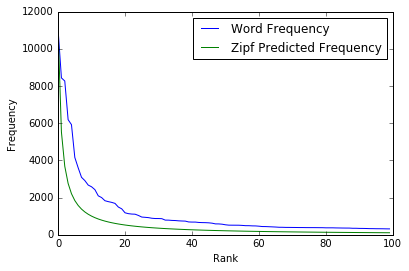

In [9]:
words_lower = []
for word in words:
    words_lower.append(word.lower())
    
word_freq = FreqDist(words_lower)
most_common_words = word_freq.most_common()[:100]

n = most_common_words[0][1]
nums = []
nums.append(n)
counter = 1
while len(nums) < 100:
    counter += 1
    nums.append(n * (1.0/counter))


# Plot actual frequencies and Zipf frequencies
plot([b for (a,b) in most_common_words], label = 'Word Frequency') # Blue
plot(nums, label = 'Zipf Predicted Frequency') # Green
legend(loc='best')
xlabel('Rank')
ylabel('Frequency')

### Top 10 Words after Stemming and Removing Stop Words

In [10]:
filtered_words = [word for word in words_lower if word not in stopwords.words('english')]
from nltk.stem.porter import PorterStemmer
PS = PorterStemmer()

stem_words = []

for word in filtered_words:
    stem_word = PS.stem(word)
    stem_words.append(stem_word)

In [11]:
# Find 10 most frequent words
words_freq_no_stops = nltk.FreqDist(stem_words)
top10_words = words_freq_no_stops.most_common()[:10]

top10_words

[(u'work', 2155),
 (u'manag', 2114),
 (u'experi', 1714),
 (u'develop', 1281),
 (u'role', 1276),
 (u'team', 1223),
 (u'busi', 1158),
 (u'client', 1152),
 (u'requir', 1018),
 (u'skill', 1013)]

# Part B

In [12]:
import numpy as np

jobs_b = jobs[['FullDescription', 'SalaryNormalized']]
jobs_b_sample = jobs_b.sample(50000)
#Create new classifier for job posting salaries in the top quartile
sal_75 = jobs_b_sample['SalaryNormalized'].quantile(.75)

jobs_b_sample['salary_class'] = np.where(jobs_b_sample['SalaryNormalized']>=sal_75,'high','low')

jobs_b_sample.head()

,FullDescription,SalaryNormalized,salary_class
156772,TM1 Consultant / TM1 Developer Hampshire / Be...,54999,high
139012,We are currently recruiting on behalf of a lar...,28000,low
151925,"Senior Network Engineer, Cisco, Juniper, Route...",75000,high
10510,Permanent Accounts Payable City Centre Client...,17000,low
42809,The research of the Clinical Epidemiology Grou...,35753,low


In [13]:
descriptions = []
pay = []

for index, value in jobs_b_sample.iterrows():
    descriptions.append(value['FullDescription'])
    pay.append(value['salary_class'])


In [14]:
#Split data into test/training set
trainset_size = int(round(len(jobs_b_sample)*0.75))

X_train = np.array([''.join(el) for el in descriptions[0:trainset_size]])
y_train = np.array([el for el in pay[0:trainset_size]])

X_test = np.array([''.join(el) for el in descriptions[trainset_size+1:len(descriptions)]]) 
y_test = np.array([el for el in pay[trainset_size+1:len(pay)]]) 

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = None)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [16]:
from sklearn.naive_bayes import MultinomialNB

#Run Naive Bayes Classifier
nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [17]:
from sklearn import metrics
print 'Precision:' + str(metrics.precision_score(y_test, y_nb_predicted, average = 'micro', pos_label='high'))
print 'Recall: ' + str(metrics.recall_score(y_test, y_nb_predicted, average = 'micro', pos_label='high'))
print 'Accuracy: ' + str(metrics.accuracy_score(y_test, y_nb_predicted))

Precision:0.569949378739
Recall: 0.770211442786
Accuracy: 0.791343307465


C:\Users\zack_\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Users\zack_\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


C:\Users\zack_\Anaconda2\lib\site-packages\seaborn\matrix.py:134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
C:\Users\zack_\Anaconda2\lib\site-packages\seaborn\matrix.py:142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


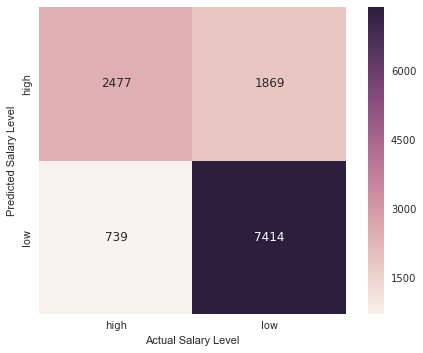

In [18]:
#Fancy boy confusion matrix
import seaborn as sns; sns.set()

mat = metrics.confusion_matrix(y_test, y_nb_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=unique(pay), yticklabels=unique(pay))
plt.xlabel('Actual Salary Level')
plt.ylabel('Predicted Salary Level');

### B2


### B3

In [19]:
#Split data into test/training set
trainset_size = int(round(len(jobs_b_sample)*0.75))

X_train = np.array([''.join(el) for el in descriptions[0:trainset_size]])
y_train = np.array([el for el in pay[0:trainset_size]])

X_test = np.array([''.join(el) for el in descriptions[trainset_size+1:len(descriptions)]]) 
y_test = np.array([el for el in pay[trainset_size+1:len(pay)]]) 

In [20]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = 'english',   \
                             max_features = 10000)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#Run Naive Bayes Classifier
nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

print 'Precision:' + str(metrics.precision_score(y_test, y_nb_predicted, average = 'binary', pos_label='high'))
print 'Recall: ' + str(metrics.recall_score(y_test, y_nb_predicted, average = 'binary', pos_label='high'))
print 'Accuracy: ' + str(metrics.accuracy_score(y_test, y_nb_predicted))

Precision:0.551524259339
Recall: 0.79881840796
Accuracy: 0.781102488199


In [21]:

def most_informative_features(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print class_labels[0], coef, feat

    print

    for coef, feat in reversed(topn_class2):
        print class_labels[1], coef, feat

In [22]:
most_informative_features(vectorizer, nb_classifier)

high -15.1509033901 9632
high -15.1509033901 actuary
high -15.1509033901 clas
high -15.1509033901 etrm
high -15.1509033901 murex
high -15.1509033901 netezza
high -15.1509033901 pega
high -15.1509033901 tm1
high -14.4577562095 biostatistics
high -14.4577562095 ccse

low -4.43453197535 experience
low -4.75442837188 work
low -4.77273566039 role
low -4.85594823905 team
low -4.97411163301 skills
low -4.98332229987 sales
low -5.0030588898 working
low -5.01547113025 business
low -5.18636777595 client
low -5.22540975725 company


### B4

In [23]:
#Split data into test/training set
trainset_size = int(round(len(jobs_b_sample)*0.75))

X_train = np.array([''.join(el) for el in descriptions[0:trainset_size]])
y_train = np.array([el for el in pay[0:trainset_size]])

X_test = np.array([''.join(el) for el in descriptions[trainset_size+1:len(descriptions)]]) 
y_test = np.array([el for el in pay[trainset_size+1:len(pay)]]) 